# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


In [1]:
import numpy as np
import pandas as pd
import keras as k
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def transform(df):
    images = []
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1-band_2
        
        
        # Feature scaling
        band_1_norm = (band_1 - band_1.mean()) / band_1.std() 
        band_2_norm = (band_2 - band_2.mean()) / band_2.std()
        band_3_norm = (band_3 - band_3.mean()) / band_3.std()
        images.append(np.dstack((band_1_norm, band_2_norm, band_3_norm)))
    return np.array(images)

In [3]:
def augment(images):
    image_rot90 = []
    image_rot180 = []
    image_rot270 = []
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
        
        # rotate 90
        band_1_rot90 = np.rot90(band_1)
        band_2_rot90 = np.rot90(band_2)
        band_3_rot90 = np.rot90(band_3)
        image_rot90.append(np.dstack((band_1_rot90, band_2_rot90, band_3_rot90)))
        
        # rotate 180
        band_1_rot180 = np.rot90(band_1_rot90)
        band_2_rot180 = np.rot90(band_2_rot90)
        band_3_rot180 = np.rot90(band_3_rot90)
        image_rot180.append(np.dstack((band_1_rot180, band_2_rot180, band_3_rot180)))
        
        # rotate 270
        band_1_rot270 = np.rot90(band_1_rot180)
        band_2_rot270 = np.rot90(band_2_rot180)
        band_3_rot270 = np.rot90(band_3_rot180)
        image_rot270.append(np.dstack((band_1_rot270, band_2_rot270, band_3_rot270)))
        
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
    rot90 = np.array(image_rot90)
    rot180 = np.array(image_rot180)
    rot270 = np.array(image_rot270)
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    images = np.concatenate((images, rot90, rot180, rot270, mirrorlr, mirrorud))
    return images

In [5]:
test = pd.read_json('../data/test.json')

In [6]:
train = pd.read_json('../data/train.json')

In [7]:
test.inc_angle = test.inc_angle.replace('na',0)
test_X = transform(test)

In [8]:
m = train.inc_angle[train.inc_angle != 'na'].mean()
train.inc_angle = train.inc_angle.replace('na',m)

In [9]:
from sklearn.model_selection import train_test_split
train_l = np.array(train['is_iceberg'])
train = transform(train)
train_X, val_X,  train_y, val_y = train_test_split(
    train, train_l , test_size=0.20, random_state=42)

train_X = augment(train_X)
train_y = np.concatenate((train_y, train_y, train_y, train_y, train_y, train_y))

In [10]:
model=k.models.Sequential()
model.add(k.layers.convolutional.Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.3))

model.add(k.layers.convolutional.Conv2D(32, kernel_size=(3, 3), activation='relu' ))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.2))

model.add(k.layers.convolutional.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.2))

model.add(k.layers.convolutional.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.3))

model.add(k.layers.Flatten())

model.add(k.layers.Dense(32))
model.add(k.layers.Activation('relu'))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.3))

model.add(k.layers.Dense(32))
model.add(k.layers.Activation('relu'))
model.add(k.layers.BatchNormalization())
model.add(k.layers.Dropout(0.3))

model.add(k.layers.Dense(1))
model.add(k.layers.Activation('sigmoid'))

adam=k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 17, 17, 32)        128       
__________

In [11]:
timeline = model.fit(train_X, train_y, batch_size=32, epochs=50, verbose=1, validation_data=(val_X, val_y))

Train on 7698 samples, validate on 321 samples
Epoch 1/50
7698/7698 [==============================] - 79s 10ms/step - loss: 0.4922 - acc: 0.7482 - val_loss: 0.8706 - val_acc: 0.5607
Epoch 2/50
7698/7698 [==============================] - 32s 4ms/step - loss: 0.3538 - acc: 0.8398 - val_loss: 0.3309 - val_acc: 0.8660
Epoch 3/50
7698/7698 [==============================] - 32s 4ms/step - loss: 0.3213 - acc: 0.8613 - val_loss: 0.2562 - val_acc: 0.8972
Epoch 4/50
7698/7698 [==============================] - 32s 4ms/step - loss: 0.3029 - acc: 0.8705 - val_loss: 0.4543 - val_acc: 0.8131
Epoch 5/50
7698/7698 [==============================] - 31s 4ms/step - loss: 0.2957 - acc: 0.8730 - val_loss: 0.2620 - val_acc: 0.8754
Epoch 6/50
7698/7698 [==============================] - 32s 4ms/step - loss: 0.2857 - acc: 0.8802 - val_loss: 0.2516 - val_acc: 0.8941
Epoch 7/50
7698/7698 [==============================] - 32s 4ms/step - loss: 0.2700 - acc: 0.8897 - val_loss: 0.2618 - val_acc: 0.8816
Epoch 8

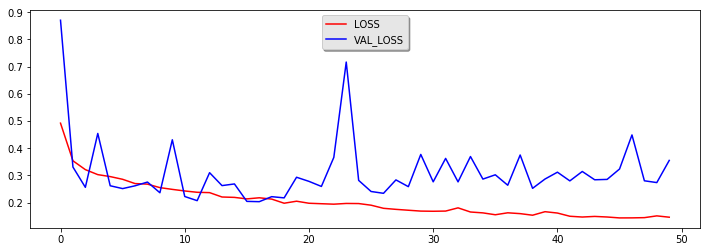

In [12]:
fig, ax = plt.subplots(figsize=(12,4))

plt.plot(timeline.history['loss'], color='red', label='LOSS')
plt.plot(timeline.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [13]:
pred_test = model.predict(test_X)

In [14]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
submission

,id,is_iceberg
0,5941774d,0.004231
1,4023181e,0.722919
2,b20200e4,0.101240
3,e7f018bb,0.909205
4,4371c8c3,0.998253
5,a8d9b1fd,0.002582
6,29e7727e,0.001983
7,92a51ffb,0.968045
8,c769ac97,0.004958
9,aee0547d,0.004250


In [15]:
submission.to_csv('../submission/submission8.csv', index=False)